In [ ]:
import cv2
import numpy as np
from IPython.display import display, clear_output
from PIL import Image

# Load the video
cap = cv2.VideoCapture(r'/content/cv_bg_sub.mp4')

# Parameters for Lucas-Kanade
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Read the first frame
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Detect features to track
p0 = cv2.goodFeaturesToTrack(old_gray, maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Process each frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Draw motion vectors
    if p1 is not None:
        for i, (new, old) in enumerate(zip(p1, p0)):
            a, b = new.ravel()
            c, d = old.ravel()
            cv2.line(frame, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
            cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

    # Update old frame and points
    old_gray = frame_gray.copy()
    p0 = p1[st == 1].reshape(-1, 1, 2)

    # Convert to displayable format and show in Jupyter Notebook
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    clear_output(wait=True)
    display(img)

cap.release()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cap = cv2.VideoCapture(r"/content/cv_bg_sub.mp4")
background = None
while True:
    r, f = cap.read()
    if not r:
        break
    g = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
    gf=cv2.resize(f,(500,500))
    if background is None:
        background = gf.astype("float")
        continue
    cv2.accumulateWeighted(gf, background, 0.01)  # learning rate
    diff_frame = cv2.absdiff(gf, cv2.convertScaleAbs(background))
    _, fg_mask = cv2.threshold(diff_frame, 25, 255, cv2.THRESH_BINARY)
    cv2.imshow('original',gf)
    cv2.imshow('Foreground Mask', fg_mask)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow


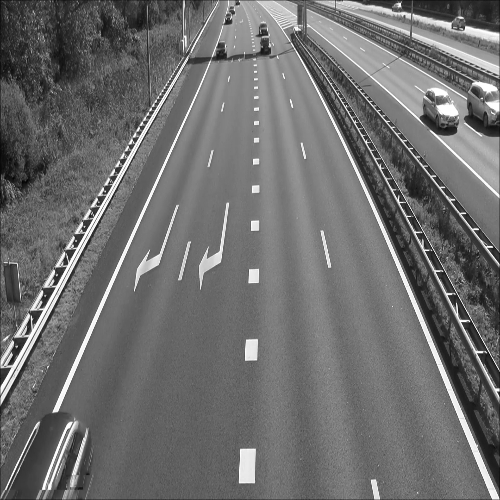

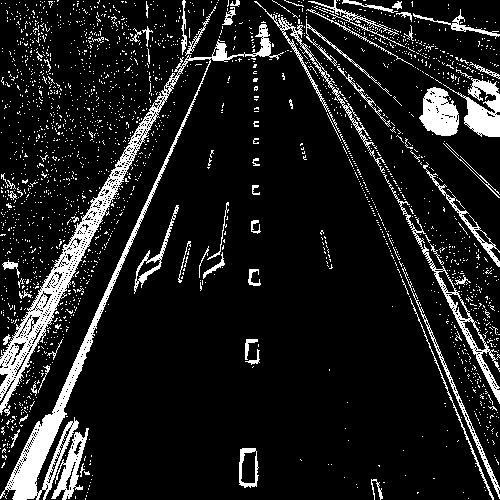

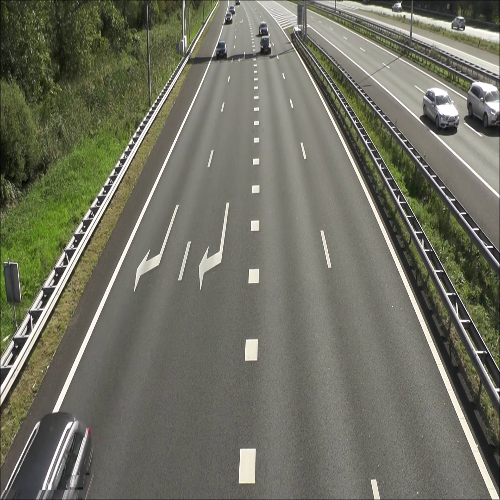

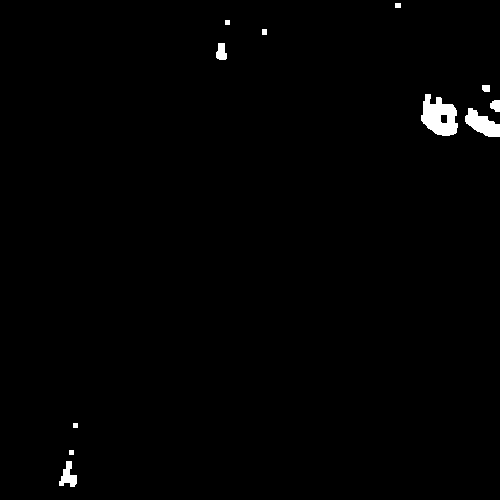

In [ ]:
import cv2
import numpy as np
from IPython.display import display, clear_output
from PIL import Image

# Load the video
c = cv2.VideoCapture(r"/content/cv_bg_sub.mp4")

# Initialize background subtractor
bg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=100, detectShadows=False)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# Read the first frame
ret, prev_frame = c.read()
prev_frame = cv2.resize(prev_frame, (500, 500))
prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

while c.isOpened():
    ret, frame = c.read()
    if not ret:
        break

    # Resize and convert to grayscale
    frame_resized = cv2.resize(frame, (500, 500))
    gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)

    # Compute absolute difference
    diff = cv2.absdiff(prev_frame, gray)
    _, diff_thresh = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)

    # Detect scene change
    if np.sum(diff_thresh) > 5_000_000:
        print("Scene Change Detected")
        bg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=100, detectShadows=False)

    prev_frame = gray.copy()

    # Apply background subtraction
    fg = bg.apply(frame_resized)

    # Apply morphological operations to reduce noise
    fg = cv2.morphologyEx(fg, cv2.MORPH_OPEN, kernel)
    fg = cv2.morphologyEx(fg, cv2.MORPH_CLOSE, kernel)

    # Convert frames to displayable format
    original_img = Image.fromarray(cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB))
    motion_img = Image.fromarray(fg)

    # Clear output and display images in Jupyter Notebook
    clear_output(wait=True)
    display(original_img, motion_img)

c.release()
